# 5. Explainability 

In this section, we make a study of the explainability of the private database using Lime

#### Importation of the librairies needed

In [22]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("dependencies")

from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
import xgboost as xgboost

import pandas as pd
import numpy as np
import sklearn

import math
import random


# Load and preprocess the dataset

In [23]:
# Load Dataset
feature_names = [
    "Age", "Workclass", "Education","Marital Status", "Occupation", "Relationship", 
    "Race", "Sex", "Capital Gain","Capital Loss", "Hours per week", "Country", 
    "label"
]

# Load the dataset into a DataFrame
df = pd.DataFrame(
  np.genfromtxt('adult.data', delimiter=', ', dtype=str, usecols=(0,1,3,5,6,7,8,9,10,11,12,13,14)),    
  columns=feature_names
)


#Drop missing values denoted as "?"
cols = list(df.columns)
df[cols] = df[cols].replace(['?'], np.nan)
df = df.dropna()

# Binarize age
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
median_age = df['Age'].median()

# Create binary columns for 'Age' and 'Sex'
df['age_binary'] = df['Age'].apply(lambda x: 0 if x <= median_age else 1)
df['sex_binary'] = df['Sex'].apply(lambda x: 0 if x == 'Female' else 1)

# Drop the original 'Age' and 'Sex' columns
df = df.drop('Age', axis=1)
df = df.drop('Sex', axis=1)

# Convert the 'label' column to binary
df["label"] = df["label"].replace('>50K',1)
df["label"] = df["label"].replace('<=50K',0)

# Print the first few rows of the DataFrame
print(df.head())



          Workclass  Education      Marital Status         Occupation  \
0         State-gov  Bachelors       Never-married       Adm-clerical   
1  Self-emp-not-inc  Bachelors  Married-civ-spouse    Exec-managerial   
2           Private    HS-grad            Divorced  Handlers-cleaners   
3           Private       11th  Married-civ-spouse  Handlers-cleaners   
4           Private  Bachelors  Married-civ-spouse     Prof-specialty   

    Relationship   Race Capital Gain Capital Loss Hours per week  \
0  Not-in-family  White         2174            0             40   
1        Husband  White            0            0             13   
2  Not-in-family  White            0            0             40   
3        Husband  Black            0            0             40   
4           Wife  Black            0            0             40   

         Country  label  age_binary  sex_binary  
0  United-States      0           1           1  
1  United-States      0           1           1  
2 

### Apply LDP on data set 

In [24]:
# Define functions for local differential privacy
def get_epsilon(p=0.75, q=0.75):
    return math.log( max(q/(1-p), p/(1-q)) )

def rand_resp(x, p=0.75, q=0.75):
    toss = random.random()
    if x == 0:
        y = 0 if toss <= q else 1
    else:
        y = 1 if toss <= p else 0
    return y

In [39]:
# Create a copy of the original DataFrame
df_private = df.copy()
epsilon = get_epsilon()

# Apply local differential privacy to 'age_binary' and 'sex_binary' columns
df_private['age_binary_private'] = df_private['age_binary'].apply(lambda x: rand_resp(x))
df_private['sex_binary_private'] = df_private['sex_binary'].apply(lambda x: rand_resp(x))

# Drop the original 'age_binary' and 'sex_binary' columns
df_private = df_private.drop('age_binary', axis=1)
print("columns : ", df_private.columns)

# Define feature names and categorical columns
feature_names = [
    "age_binary_private", "Workclass", "Education","Marital Status", "Occupation", "Relationship", 
    "Race", "sex_binary_private", "Capital Gain","Capital Loss", "Hours per week", "Country", 
    "label"
]
categorical_columns=[
   "Workclass", "Education", "Marital Status", "Occupation", "Relationship", "Race", "sex_binary_private", 'age_binary_private', "Country", "label"
]

# Convert columns to appropriate data types
for feature in feature_names:
    if feature in categorical_columns:
        df_private[feature] = df_private[feature].astype("category")
    else:
        df_private[feature] = df_private[feature].astype("int64")
        
# Print the data types of the DataFrame
print(df_private.dtypes)

columns :  Index(['Workclass', 'Education', 'Marital Status', 'Occupation',
       'Relationship', 'Race', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Country', 'label', 'sex_binary',
       'age_binary_private', 'sex_binary_private'],
      dtype='object')
Workclass             category
Education             category
Marital Status        category
Occupation            category
Relationship          category
Race                  category
Capital Gain             int64
Capital Loss             int64
Hours per week           int64
Country               category
label                 category
sex_binary               int64
age_binary_private    category
sex_binary_private    category
dtype: object


### Split and Train Data

In [26]:
# Data preprocessing to train model
columns = [
    "age_binary_private", "Workclass", "Education","Marital Status", "Occupation", "Relationship", 
    "Race", "sex_binary_private", "Capital Gain","Capital Loss", "Hours per week", "Country"]

# Create a Tabular object for the private data
tabular_data = Tabular(
   df_private,
   categorical_columns=columns,
   target_column='label'
)

# Divide into training and test set
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.70,random_state = 1234)

# Convert test labels to integers
test_labels = test_labels.astype(int)

# Print the shapes of the training and test data
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

# Train an XGBoost model
model = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
model.fit(train, train_labels)

# Define a prediction function
predict_function=lambda z: model.predict_proba(transformer.transform(z))


# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

# Display the target column and the first two training labels
display(tabular_data.target_column)
display(train_labels[:2])

Training data shape: (21113, 404)
Test data shape:     (9049, 404)


'label'

array([0., 0.])

### Create a DataFrame for the test data and add prediction columns


In [27]:
test_df = test_data.to_pd()
test_df["income-per-year"] = test_labels
predictions = model.predict(test)
test_df["prediction"] = predictions

# Display a sample of the test DataFrame
test_df.sample(5)

,Workclass,Education,Marital Status,Occupation,Relationship,Race,Capital Gain,Capital Loss,Hours per week,Country,age_binary,sex_binary,age_binary_private,sex_binary_private,income-per-year,prediction
3279,Federal-gov,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,0,0,40,United-States,1.0,1.0,1,1,1,1
8894,Self-emp-not-inc,Bachelors,Never-married,Exec-managerial,Not-in-family,White,0,0,40,United-States,0.0,1.0,0,1,0,0
3953,Private,HS-grad,Divorced,Craft-repair,Not-in-family,Asian-Pac-Islander,10520,0,40,United-States,1.0,1.0,1,1,1,1
842,Local-gov,Bachelors,Never-married,Prof-specialty,Not-in-family,White,0,0,40,United-States,0.0,0.0,0,0,0,0
498,Private,Bachelors,Never-married,Exec-managerial,Not-in-family,White,0,0,50,United-States,0.0,0.0,0,0,0,0


### Study of the explainability of the private classifier


In [28]:
#Initialize the explainers for the private classifier
explainers = TabularExplainer(
    explainers=["ale", "shap_global"],                 # The explainers to apply
    mode="classification",                             # The task type
    data= train_data,                                   # The data for initializing the explainers
    model=model,                                       # The ML model to explain
    preprocess=lambda z: transformer.transform(z),       # Converts raw features into the model inputs
)

# Generate global explanations
global_explanations = explainers.explain_global()

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
# Print ALE results and plot the explanations
print("ALE results:")
global_explanations["ale"].ipython_plot(class_names=transformer.class_names)

ALE results:


SHAP results:


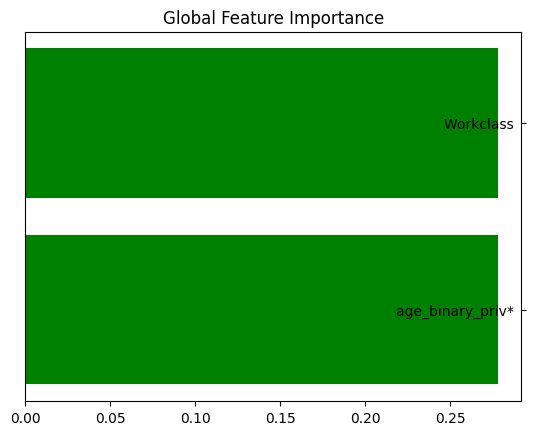

In [37]:
# Print SHAP results and plot the explanations
print("SHAP results:")
global_explanations["shap_global"].ipython_plot(class_names=transformer.class_names)



### Identify instances where the model is wrong but highly confident :

In [ ]:
# Find instances where the predicted label is different from the actual label
miss_indices = np.where(predictions != test_labels)[0]

# Create the prediction probabilities
proba = model.predict_proba(test)

# Find instances where the model is very confident but wrong
miss_but_confident = []

for idx in miss_indices:
    if max(proba[idx]) > 0.95:
        miss_but_confident.append(idx)
    
# Print the number of instances where the model is very confident but wrong
print(f"There are {len(miss_but_confident)} instances where the model is very confident but wrong.")

instance_ids = miss_but_confident

# Print an example of a highly confident but wrong prediction
print(f"For example, instance {instance_ids[0]} has label {test_labels[instance_ids[0]]} and prediction {predictions[instance_ids[0]]}, with probs {model.predict_proba(test[instance_ids[0]:instance_ids[0]+1])[0]}")

### Explanation of instances where the model is wrong but highly confident.

In [ ]:
# Initialize the explainers for the identified instances
explainers = TabularExplainer(
  explainers=['lime', 'mace'],                       # The explainers to apply
  mode="classification",                             # The task type
  data=train_data,                                   # The data for initializing the explainers
  model=model,                                       # The ML model to explain
  preprocess=lambda z: transformer.transform(z),     # Converts raw features into the model inputs
  params={
        "mace": {"ignored_features": ["age_binary_private", "sex_binary_private"]}# params which cannot change when creating counterfactuals
    }
)
# Select the instances to explain
test_instances = test_data[instance_ids]
#test_instances = test_instances[:10]
local_explanations = explainers.explain(X=test_instances)

### LIME explanations for the identified instances

In [ ]:
print("LIME explanation")

for i, instance_id in enumerate(instance_ids):
    print(f"Instance {instance_id} has {test_labels[instance_id]} and prediction {predictions[instance_id]}, with probs {model.predict_proba(test[instance_id:instance_id+1])[0]}")
    local_explanations["lime"].ipython_plot(index=i, class_names=class_names)

### MACE explanations for the identified instances

In [ ]:
print("MACE results:")


for expl_id, instance_id in enumerate(instance_ids):
    
    query_df = local_explanations['mace'].get_explanations()[expl_id]['query'].reset_index(drop=True)
    query_df.index = [f"{instance_id}"] * len(query_df)
    # display(query_df)


    counter_df = local_explanations['mace'].get_explanations()[expl_id]['counterfactual'].reset_index(drop=True)
    counter_df.index = [ f"CF[{cnt}] for {instance_id}" for cnt in range(len(counter_df))]
    # display(counter_df)

    combined_df = pd.concat([query_df, counter_df])


    # Highlighting function
    def highlight_changes(row):
        instance_row = combined_df.iloc[0]  # Reference row for the instance
        return ["color: red" if row[col] != instance_row[col] else "" for col in combined_df.columns]

    # Apply the style & display the styled DataFrame
    styled_df = combined_df.style.apply(highlight_changes, axis=1)
    
    display(styled_df) 



###  Investigate whether the noisy values for these attributes are responsible for the model being confident and wrong.

In [ ]:
# Extract factual and counterfactual data for the instance
factual_df = combined_df.loc[[f'{instance_id}']].reset_index(drop=True)
display(factual_df)

counter_df = combined_df.loc[[f'CF[0] for {instance_id}']].reset_index(drop=True)
display(counter_df)

# Combine factual and counterfactual data
the_df = pd.concat([factual_df, counter_df])

tabular_data = Tabular(
   the_df,
   categorical_columns=columns,
   target_column='label',
)

x = transformer.transform(tabular_data)[:,:-1]
display(x)


# Predict and print the results for factual and counterfactual data
prediction = model.predict(x)
probability = model.predict_proba(x)

print(f"Prediction for factual {instance_id}: {prediction[0]} with probability {probability[0]}")
print(f"Prediction for counterfactual {instance_id}: {prediction[1]} with probability {probability[1]}")